CNN-LSTM train-test with 6-axis imu + pressure

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping

In [2]:
# File folder_location for the dataset
folder_path ='/var/stat-dataset'
# Get the list of all files in the folder_location
file_list = os.listdir(folder_path)
# Loop via the list of files & read them into pd
dataframes = []
for file_name in file_list:
    if file_name.endswith(".csv"):  # respective activity files in csv format
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)
# Combine all files into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head(n=8)  # display the no of rows

,g0X_LSM6DSL,g0Y_LSM6DSL,g0Z_LSM6DSL,a0X_LSM6DSL,a0Y_LSM6DSL,a0Z_LSM6DSL,m0X_LSM303AH,m0Y_LSM303AH,m0Z_LSM303AH,ECG-Data,Pres,classes,Subjects
0,0.13125,-0.192500,-0.315000,-0.999424,0.044408,-0.066856,-0.144000,-0.117000,-0.267000,4136087,1015.251221,1,subject_j
1,0.17500,-0.190256,-0.304904,-0.999893,0.044564,-0.066137,-0.142269,-0.120077,-0.265269,4134388,1015.251242,1,subject_j
2,0.21875,-0.188013,-0.294808,-1.000362,0.044721,-0.065417,-0.140538,-0.123154,-0.263538,4133984,1015.251264,1,subject_j
3,0.26250,-0.185769,-0.284712,-1.000832,0.044877,-0.064698,-0.138808,-0.126231,-0.261808,4134401,1015.251285,1,subject_j
4,0.30625,-0.183526,-0.274615,-1.001301,0.045034,-0.063978,-0.137077,-0.129308,-0.260077,4135513,1015.251306,1,subject_j
5,0.35000,-0.181282,-0.264519,-1.001770,0.045190,-0.063259,-0.135346,-0.132385,-0.258346,4136887,1015.251327,1,subject_j
6,0.39375,-0.179038,-0.254423,-1.002239,0.045346,-0.062539,-0.133615,-0.135462,-0.256615,4137923,1015.251349,1,subject_j
7,0.43750,-0.176795,-0.244327,-1.002709,0.045503,-0.061820,-0.131885,-0.138538,-0.254885,4138576,1015.251370,1,subject_j


In [3]:
# Checking for missing values in the df
combined_df.isna().sum(axis=0).to_frame('Total')

,Total
g0X_LSM6DSL,0
g0Y_LSM6DSL,0
g0Z_LSM6DSL,0
a0X_LSM6DSL,0
a0Y_LSM6DSL,0
a0Z_LSM6DSL,0
m0X_LSM303AH,0
m0Y_LSM303AH,0
m0Z_LSM303AH,0
ECG-Data,0


In [4]:
#save the complete dataset
#combined_df.to_csv('statcon-built-big-data.csv', index=False)

In [5]:
# Class labels in the dataframe (df)
unique_label = np.unique(combined_df.classes)
class_label = np.sort(unique_label)
print(class_label)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
# Subjects in the data collection experiments
unique_subjects = np.unique(combined_df.Subjects)
subjects = np.sort(unique_subjects)
print(subjects)

['subject_a' 'subject_b' 'subject_c' 'subject_d' 'subject_e' 'subject_f'
 'subject_g' 'subject_h' 'subject_i' 'subject_j']


In [7]:
# Display info of the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380600 entries, 0 to 1380599
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   g0X_LSM6DSL   1380600 non-null  float64
 1   g0Y_LSM6DSL   1380600 non-null  float64
 2   g0Z_LSM6DSL   1380600 non-null  float64
 3   a0X_LSM6DSL   1380600 non-null  float64
 4   a0Y_LSM6DSL   1380600 non-null  float64
 5   a0Z_LSM6DSL   1380600 non-null  float64
 6   m0X_LSM303AH  1380600 non-null  float64
 7   m0Y_LSM303AH  1380600 non-null  float64
 8   m0Z_LSM303AH  1380600 non-null  float64
 9   ECG-Data      1380600 non-null  int64  
 10  Pres          1380600 non-null  float64
 11  classes       1380600 non-null  int64  
 12  Subjects      1380600 non-null  object 
dtypes: float64(10), int64(2), object(1)
memory usage: 136.9+ MB


In [8]:
# Convert "ECG-Data" column from integer to float
combined_df["ECG-Data"] = combined_df["ECG-Data"].astype(float)

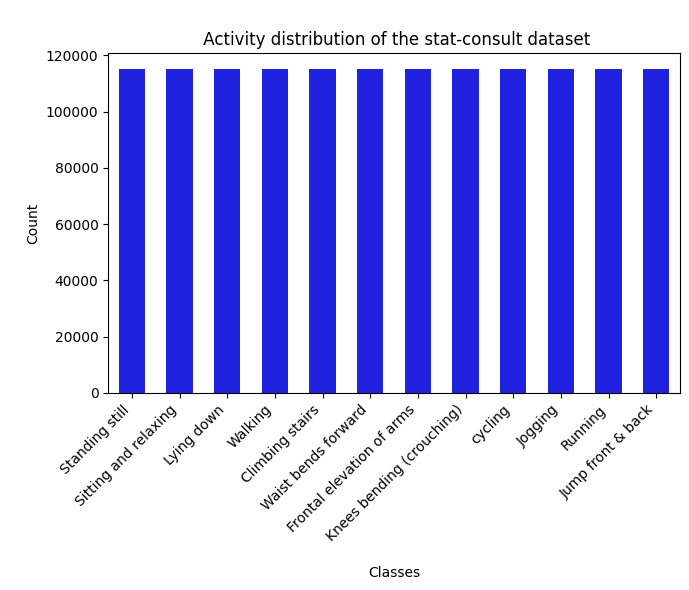

In [9]:
# Plot the number of samples present in each class_label
class_label = ['Standing still','Sitting and relaxing','Lying down','Walking', 'Climbing stairs',
               'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)','cycling',
              'Jogging','Running','Jump front & back']
plt.figure(figsize=(7, 6)) # figure sizing
num_of_classes = len(class_label)
# Creating barplot for the activitiy distribution in the df
sns.barplot(x=class_label, y=combined_df["classes"].value_counts(), color='blue', width=0.55)
# Replace the numerical x-axis ticks with class labels
plt.xticks(range(num_of_classes), class_label, rotation=45, ha='right')
# the x_axis & y_axis labels, title
plt.xlabel('\nClasses', fontsize=10)
plt.ylabel('\nCount', fontsize=10)
plt.title("\n Activity distribution of the stat-consult dataset", fontsize=12)
#display plot
plt.tight_layout()
plt.show()

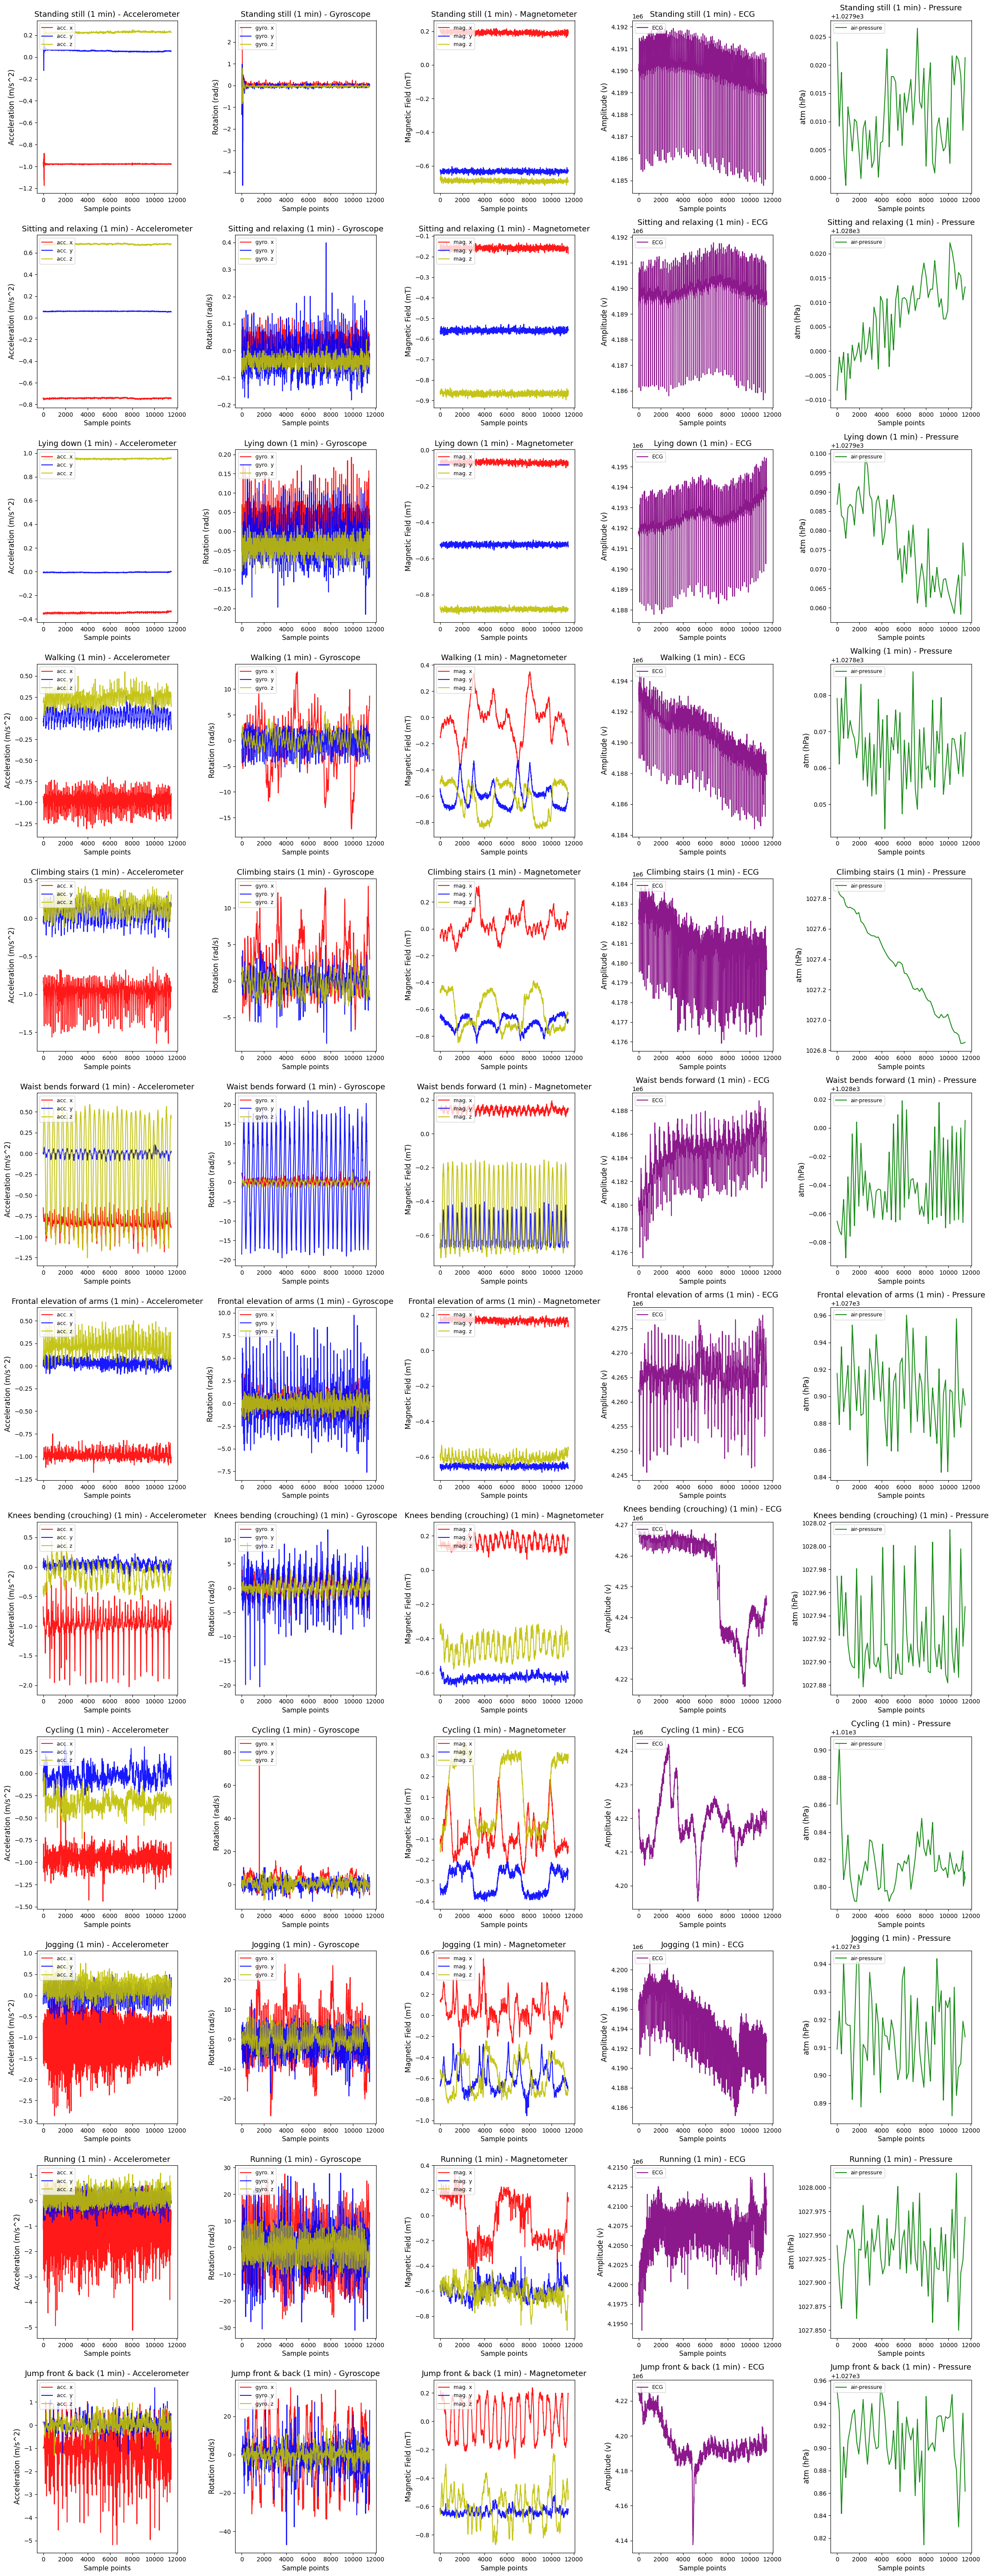

In [10]:
#Plot a subject's activity data from the list of subjects in the data collection experiment.
# Performed activities
activity_dict = {1: 'Standing still (1 min)',2: 'Sitting and relaxing (1 min)', 3: 'Lying down (1 min)', 4: 'Walking (1 min)',
    5: 'Climbing stairs (1 min)',6: 'Waist bends forward (1 min)',7: 'Frontal elevation of arms (1 min)',8: 'Knees bending (crouching) (1 min)',
    9: 'Cycling (1 min)',10: 'Jogging (1 min)',11: 'Running (1 min)', 12: 'Jump front & back (1 min)'}
#Number of rows and columns for subplots
nos_row = len(activity_dict)
nos_col = 5  # (accelerometer, gyroscope, magnetometer, ECG, and air-pressure)
#Setting subplots
fig, axs = plt.subplots(nos_row, nos_col, figsize=(23, 5 * nos_row))
# Plot for each activity
for i, activity_id in enumerate(activity_dict.keys()):
    # Filter data for the selected subject and activity
    subject_activity_data = combined_df[combined_df['Subjects'] == 'subject_b']
    # Plot accelerometer measurements for the performed activities
    axs[i, 0].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['a0X_LSM6DSL'], color='r', alpha=0.9)
    axs[i, 0].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['a0Y_LSM6DSL'], color='b', alpha=0.9)
    axs[i, 0].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['a0Z_LSM6DSL'], color='y', alpha=0.9)
    axs[i, 0].set_title(f'{activity_dict[activity_id]} - Accelerometer', fontsize=13)
    axs[i, 0].set_ylabel('Acceleration (m/s^2)', fontsize=12)
    axs[i, 0].set_xlabel('Sample points', fontsize=11)
    axs[i, 0].legend(["acc. x", "acc. y", "acc. z"], fontsize=9, loc="upper left")
    # Plot gyroscope measurements for the performed activities
    axs[i, 1].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['g0X_LSM6DSL'], c='r', alpha=0.9)
    axs[i, 1].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['g0Y_LSM6DSL'], c='b', alpha=0.9)
    axs[i, 1].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['g0Z_LSM6DSL'], c='y', alpha=0.9)
    axs[i, 1].set_title(f'{activity_dict[activity_id]} - Gyroscope', fontsize=13)
    axs[i, 1].set_ylabel('Rotation (rad/s)', fontsize=12)
    axs[i, 1].set_xlabel('Sample points', fontsize=11)
    axs[i, 1].legend(["gyro. x", "gyro. y", "gyro. z"], fontsize=9, loc="upper left")
    # Plot magnetometer measurements for the performed activities
    axs[i, 2].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['m0X_LSM303AH'], c='r', alpha=0.9)
    axs[i, 2].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['m0Y_LSM303AH'], c='b', alpha=0.9)
    axs[i, 2].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['m0Z_LSM303AH'], c='y', alpha=0.9)
    axs[i, 2].set_title(f'{activity_dict[activity_id]} - Magnetometer', fontsize=13)
    axs[i, 2].set_ylabel('Magnetic Field (mT)', fontsize=12)
    axs[i, 2].set_xlabel('Sample points', fontsize=11)
    axs[i, 2].legend(["mag. x", "mag. y", "mag. z"], fontsize=9, loc="upper left")
    # Plot ECG measurements for the performed activities
    axs[i, 3].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['ECG-Data'], c='purple', alpha=0.9)
    axs[i, 3].set_title(f'{activity_dict[activity_id]} - ECG', fontsize=13)
    axs[i, 3].set_ylabel('Amplitude (v)', fontsize=12)
    axs[i, 3].set_xlabel('Sample points', fontsize=11)
    axs[i, 3].legend(["ECG"], fontsize=9, loc="upper left")
    # Plot Pressure measurements for the performed activities
    axs[i, 4].plot(subject_activity_data[subject_activity_data['classes']==activity_id].reset_index(drop=True)['Pres'], c='g', alpha=0.9)
    axs[i, 4].set_title(f'{activity_dict[activity_id]} - Pressure', fontsize=13)
    axs[i, 4].set_ylabel('atm (hPa)', fontsize=12)
    axs[i, 4].set_xlabel('Sample points', fontsize=11)
    axs[i, 4].legend(["air-pressure"], fontsize=9, loc="upper left")

# Adjust the layout
plt.tight_layout()
plt.show()

In [11]:
# Drop column 'Subjects' from the dataframe
combined_df=combined_df.drop(['Subjects'], axis=1)

In [12]:
#selecting features to be trained and tested with the model: train & test with IMU + presuure >> step-2
# Drop column 'ecg-data' from the dataframe
#combined_df=combined_df.drop(['ECG-Data'], axis=1)

In [13]:
# Drop 'Magnetometer and ECG readings' from the dataframe: train & test with IMU (exclude magnetometer) + presure >> step-3
combined_df=combined_df.drop(['m0X_LSM303AH', 'm0Y_LSM303AH','m0Z_LSM303AH', 'ECG-Data',], axis=1)

In [14]:
# Separating the input and output
Features =combined_df.copy() #features/input
Label = Features.pop('classes') # class/output/target

In [15]:
# Display columns of the selected features (input variables)
Features.columns

Index(['g0X_LSM6DSL', 'g0Y_LSM6DSL', 'g0Z_LSM6DSL', 'a0X_LSM6DSL',
       'a0Y_LSM6DSL', 'a0Z_LSM6DSL', 'Pres'],
      dtype='object')

In [16]:
# Normalization of the features/input variables
scaler = StandardScaler()
normalized_feature = scaler.fit_transform(Features)

In [17]:
# Data-Segmentation
# Creating function for the sliding-window
#num_time_step: specifies the length of each segment/sequence
#stepsize: specifies the step-size used to slide the window over the data
def create_sequences(X, y, num_time_step, stepsize=1): # X:input y: output/target
    segment, label = [],[]
    for i in range(0,len(X) - num_time_step+1, stepsize):
        x = X[i:i + num_time_step]
        labels = y[i + num_time_step-1]
        segment.append(x)
        label.append(labels)
    return np.array(segment), np.array(label)

In [18]:
# Creating the data sequence
X_seq, y_seq = create_sequences(normalized_feature, Label, num_time_step=390, stepsize=195)
# print shape of the data
print(X_seq.shape, y_seq.shape)

(7079, 390, 7) (7079,)


In [19]:
# Divide data into 70% training set and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42, shuffle=True)

In [20]:
print (X_train.shape, y_train.shape) # print training-set shape
print (X_test.shape, y_test.shape) # print testing-set shape

(4955, 390, 7) (4955,)
(2124, 390, 7) (2124,)


In [21]:
# Convert output to one-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [22]:
# Extract window_length,number of features, number of outputs to be used in the input & ouput of the neural network
window_length,num_features,num_outputs= X_train.shape[1], X_train.shape[2],Y_train.shape[1]
print(window_length,num_features,num_outputs)

390 7 13


In [23]:
#input shape
input_shape = (window_length, num_features)

# Configuring the CNN_LSTM network architecture
model = keras.Sequential([
    # Input layer
    layers.Input(input_shape),
    # CNN-1D layers
    layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer-1
    layers.BatchNormalization(), # batch_normalization
    layers.Activation('relu'), # activation function
    layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer-2
    layers.BatchNormalization(), # batch_normalization
    layers.Activation('relu'), # activation function
    # Recurrent LSTM Layers
    layers.LSTM(units=128, return_sequences=True), # LSTM layer-1
    layers.Activation('relu'), # activation function
    layers.LSTM(units=128, return_sequences=False), # LSTM layer-2
    layers.Activation('relu'), # activation function
    # Dense layers
    layers.Dense(128, activation="relu"),
    # Activation function for the output layer 'softmax' for Multi-classification
    layers.Dense(num_outputs, activation='softmax')
])
# Summary of the model configuration
model.summary()

# Compile the model
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule) # Optimizer
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

# Training the model
history=model.fit(X_train, Y_train, epochs=26, batch_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 390, 64)           1408      
                                                                 
 batch_normalization (Batch  (None, 390, 64)           256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 390, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 390, 64)           12352     
                                                                 
 batch_normalization_1 (Bat  (None, 390, 64)           256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 390, 64)           0

In [24]:
# Model evaluation on the test set to ascertain model performance
loss, accuracy = model.evaluate(X_test,Y_test,verbose=0)
#print in %
print(f'\nTest loss in %: {loss*100:.2f}%')
print(f'\nTest accuracy in %: {accuracy*100:.2f}%')


Test loss in %: 5.27%

Test accuracy in %: 98.45%


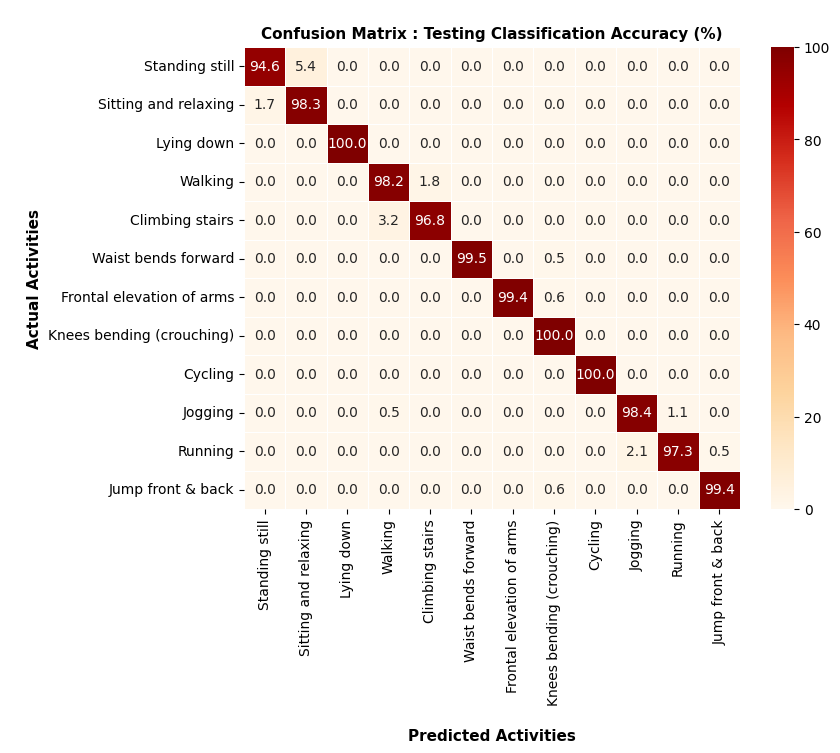

In [25]:
 # Creating classification test of the model using confusion matrix
 # Predicting on the testing set
y_pred = model.predict(X_test,verbose=0)
# Converting predictions to class_labels
predctd_label = np.argmax(y_pred, axis=1)
# Classes of the the performed activities
class_labels  = ['Standing still','Sitting and relaxing','Lying down','Walking','Climbing stairs',
                 'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)','Cycling',
                 'Jogging','Running','Jump front & back']
# Create a confusion matrix >> test set
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1),predctd_label)
# Calculate accuracy percentages for each predicted activity labels
class_lbl_accuracy = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Plot the confusion matrix with accuracy percentages for the predictions
plt.figure(figsize=(8, 6))
sns.heatmap(class_lbl_accuracy, annot=True, fmt='.1f', cmap='OrRd', xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5) #plot data
plt.title('\nConfusion Matrix : Testing Classification Accuracy (%)', fontsize=11, fontweight='bold')
plt.xlabel('\nPredicted Activities', fontsize=11, fontweight='bold')
plt.ylabel('\nActual Activities', fontsize=11, fontweight='bold')
plt.show() # display plot

In [26]:
#from keras.utils import plot_model
# Plotting the model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)